# *Monod* interpretation of parameter differences.

In this notebook, we use the mechanistic approach to analyze differences in noise between cell types and conditions.

In the first part, we reproduce and summarize the analysis in Figure 4 of "Length Biases..."

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis


In [2]:
import numpy as np
# import loompy as lp
# import matplotlib
import matplotlib.pyplot as plt
import scipy


In [3]:
param_names = ['Burst size','Splicing rate','Degradation rate']
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)

aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors_pbmc':('orange','teal','mediumvioletred'),
     'celltype_colors_allen':('lightcoral','lightseagreen'),
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'lightcoral',
}


In [4]:
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]


allen_celltype_datasets = dataset_v3_list[3][:4]
allen_celltype_batch_dir = 'gg_221119_025_allen_celltypes_1'
allen_celltype_names = ['Glutamatergic','GABAergic']
allen_celltype_names_labels = ['glutamatergic','GABAergic']
allen_celltypes = [[dataset + '_' + celltype for celltype in allen_celltype_names] for dataset in allen_celltype_datasets]
allen_markers = [['Slc17a7','Slc17a6'],
      ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]


In [5]:
par_vals_uncorrected = []
gf_rej = []
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    par_vals_uncorrected.append([x.phys_optimum for x in sr_arr_allen])
    gf_rej.append([~x.rejected_genes for x in sr_arr_allen])
#     monod.analysis.plot_params_for_pair(sr_arr_allen[0],sr_arr_allen[1],xlabel=celltype_datasets[0],ylabel=celltype_datasets[1])
par_vals_uncorrected = np.asarray(par_vals_uncorrected)
gf_rej = np.asarray(gf_rej)


Slightly debias the parameters to avoid overrejecting by $t$-test.

In [36]:
offsets = []
par_vals = np.copy(par_vals_uncorrected)
n_datasets = len(allen_celltypes)

for k in range(3):
    m1 = par_vals_uncorrected[0,0,:,k]
    for j in range(1,n_datasets):
        m2 = par_vals_uncorrected[j,0,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,0,:,k] -= offset
        offsets.append(offset)
#         print(offset)
    for j in range(n_datasets):
        m2 = par_vals_uncorrected[j,1,:,k]
        offset = monod.analysis.diffexp_fpi(m1,m2,param_names[k],viz=False)[1]
        par_vals[j,1,:,k] -= offset
        offsets.append(offset)
#         print(offset)


In [37]:
offsets=np.array(offsets).squeeze()

Text(0, 0.5, 'Number of datasets')

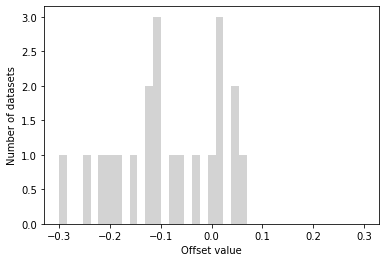

In [38]:
plt.hist(offsets,bins=np.linspace(-0.3,0.3,40),facecolor='lightgray')
plt.xlabel('Offset value')
plt.ylabel('Number of datasets')

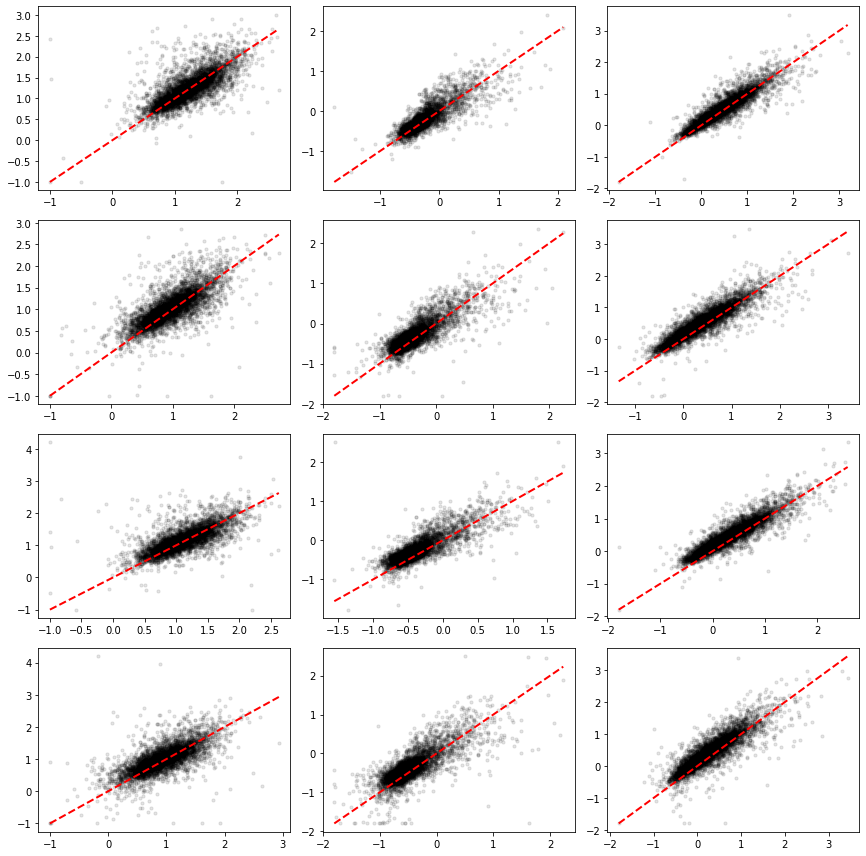

In [39]:
fig1,ax1 = plt.subplots(4,3,figsize=(12,12))
for d in range(n_datasets):
    for k in range(3):
        x=par_vals_uncorrected[d,0,:,k]
        y=par_vals_uncorrected[d,1,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()


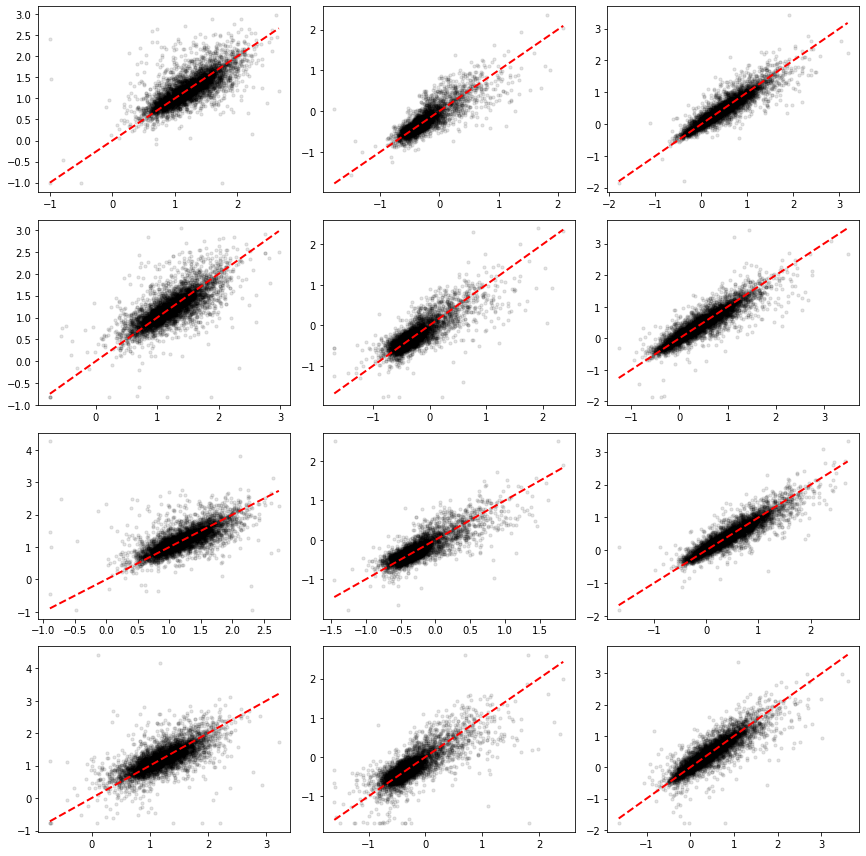

In [40]:
fig1,ax1 = plt.subplots(4,3,figsize=(12,12))
for d in range(n_datasets):
    for k in range(3):
        x=par_vals[d,0,:,k]
        y=par_vals[d,1,:,k]
        xl = [min(x),max(x)]
        ax1[d,k].scatter(x,y,10,'k',alpha=0.1) 

        ax1[d,k].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()


In [41]:
n_genes = par_vals.shape[2]


Compute $t$-test $p$-values.

In [52]:
4- gf_rej[:,1,j].sum()

4

In [59]:
p_par = np.zeros((n_genes,3))
n1 = np.zeros((n_genes,3))
n2 = np.zeros((n_genes,3))
for k in range(3):
    for j in range(n_genes):
        gf1 = gf_rej[:,0,j]
        gf2 = gf_rej[:,1,j]
        n1[j,k] = (gf1).sum()
        n2[j,k] = (gf2).sum()
        p_par[j,k] = scipy.stats.ttest_ind(par_vals[gf1,0,j,k],par_vals[gf2,1,j,k],equal_var=False)[1]


In [104]:
allen_celltypes

[['allen_B08_Glutamatergic', 'allen_B08_GABAergic'],
 ['allen_C01_Glutamatergic', 'allen_C01_GABAergic'],
 ['allen_F08_Glutamatergic', 'allen_F08_GABAergic'],
 ['allen_H12_Glutamatergic', 'allen_H12_GABAergic']]

In [66]:
# gf_rej.mean(2)

In [67]:
fc_par = ((par_vals[:,1,:,:]-par_vals[:,0,:,:])/np.log10(2)).mean(0)


In [69]:
fc_par.shape

(5000, 3)

In [44]:
gn = sr_arr_allen[0].gene_names

['Rnf152' '2010300C02Rik' 'Pip5k1c' 'Nin' 'Rap2a' 'Fzd3' 'Nr4a1' 'Dnajc21'
 'Igsf21' 'Rasgef1a' 'Igf1r' 'Stx4a' 'Rnf169' 'Mast3' 'Nectin1' 'Scg3'
 'Mras']
['Erbin' 'Mblac2' 'Mtss1' 'Arhgap12' 'Vav2' 'A530058N18Rik' 'Rcan3'
 'Ankrd6' 'Adcyap1r1' 'Crtc3' 'Egln1' 'Arpp19' 'Mid2']
['A330023F24Rik' 'Cacng5' 'Slc39a11' 'Erbin' 'B3galt5' 'Svil' 'Arhgap12'
 'Cxxc4' 'Ccdc136' 'Ank1' 'Amotl1' 'Mid2']


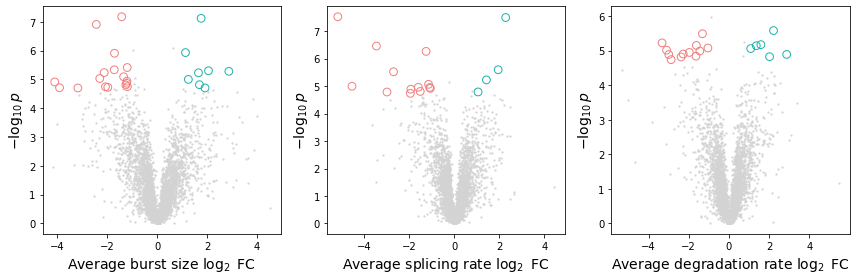

In [70]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
dr_par_multi = np.zeros((n_genes,3),dtype=bool)
pval_thr = 0.1/n_genes
gf_gaba_all = []
gf_glu_all = []
for k in range(3):
    fc_d = fc_par[:,k]
    gf_pval = p_par[:,k]<pval_thr
    
    gf_fc_gaba = fc_d>1
    gf_fc_glu = fc_d<-1
    gf_gaba = gf_pval & gf_fc_gaba
    gf_glu = gf_pval & gf_fc_glu
    
    gf_gaba_all.append(gf_gaba)
    gf_glu_all.append(gf_glu)
    
#     dr_par_multi[:,k] = gf
    gf_notselected = (~ gf_gaba) & (~ gf_glu)
    print(gn[gf_glu])
    logp_par = -np.log10(p_par[:,k])
    ax1[k].scatter(fc_d[gf_gaba],logp_par[gf_gaba],color=aesthetics['celltype_colors_allen'][1],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_glu],logp_par[gf_glu],color=aesthetics['celltype_colors_allen'][0],
                   s=aesthetics['celltype_marker_ms'],
                   alpha=1,facecolors='none')
    ax1[k].scatter(fc_d[gf_notselected],logp_par[gf_notselected],color=aesthetics['omitted_color'],\
                   s=aesthetics['omitted_markersize_body'],alpha=0.8)
    ax1[k].set_ylabel(r'$-\log_{10} p$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Average ' + param_names[k].lower()+' $\log_2$ FC',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
# fig1.savefig('./'+figdir+'/volcano.png',dpi=600)


In [73]:
# pval_thr

We have now reproduced Fig. 4d of "Length Biases." Now, let's focus on the genes that *also* have a low average log fold change...

In [194]:
log2_fc_spliced = np.zeros((n_genes,len(allen_celltypes)))
for k,celltype_datasets in enumerate(allen_celltypes):
    sd_arr_allen = [monod.analysis.load_search_data('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]
    log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))
mean_log2_fc_spliced = log2_fc_spliced.mean(1)


/tmp/ipykernel_2165842/973810421.py:4: RuntimeWarning: divide by zero encountered in log2
  log2_fc_spliced[:,k] = np.log2(sd_arr_allen[1].layers[1].mean(1)/sd_arr_allen[0].layers[1].mean(1))


In [195]:
spliced_fc_gf = (np.abs(mean_log2_fc_spliced)<1)

In [197]:
logp_par = -np.log10(p_par)

Next, let's define an "aggregated" version of fold change parameters. We use the negative average of splicing rate and degradation rate change to estimate the burst frequency change.

In [198]:
deltaB = fc_par[:,0]
deltaK = -(fc_par[:,1]+fc_par[:,2])/2

In [200]:
gf_glu_all = np.asarray(gf_glu_all)
gf_gaba_all = np.asarray(gf_gaba_all)

In [201]:
gf_gaba_all.shape

(3, 5000)

In [202]:
deltaB.shape

(5000,)

In [83]:
import pandas as pd

In [123]:
df = pd.DataFrame.from_dict({'Gene':gn,'burst_size_l2fc':fc_par[:,0],'burst_size_pval':p_par[:,0],'n_glut':n1[:,0],'n_gaba':n2[:,0]})
df['n_glut']=df['n_glut'].astype(int)
df['n_gaba']=df['n_gaba'].astype(int)
df = df[(df['burst_size_l2fc'].abs()>1) & (df['burst_size_pval']<pval_thr)]

df = df.sort_values('burst_size_l2fc').set_index('Gene')
df.to_csv('/home/ggorin/monod_fit_package/pvals/burst_size.csv')

In [124]:
df = pd.DataFrame.from_dict({'Gene':gn,'splicing_rate_l2fc':fc_par[:,1],'splicing_rate_pval':p_par[:,1],'n_glut':n1[:,1],'n_gaba':n2[:,1]})
df['n_glut']=df['n_glut'].astype(int)
df['n_gaba']=df['n_gaba'].astype(int)
df = df[(df['splicing_rate_l2fc'].abs()>1) & (df['splicing_rate_pval']<pval_thr)]

df = df.sort_values('splicing_rate_l2fc').set_index('Gene')
df.to_csv('/home/ggorin/monod_fit_package/pvals/splicing_rate.csv')

In [126]:
df = pd.DataFrame.from_dict({'Gene':gn,'degradation_rate_l2fc':fc_par[:,2],'degradation_rate_pval':p_par[:,2],'n_glut':n1[:,2],'n_gaba':n2[:,2]})
df['n_glut']=df['n_glut'].astype(int)
df['n_gaba']=df['n_gaba'].astype(int)
df = df[(df['degradation_rate_l2fc'].abs()>1) & (df['degradation_rate_pval']<pval_thr)]

df = df.sort_values('degradation_rate_l2fc').set_index('Gene')
df.to_csv('/home/ggorin/monod_fit_package/pvals/degradation_rate.csv')

In [127]:
df

,degradation_rate_l2fc,degradation_rate_pval,n_glut,n_gaba
Gene,,,,
Erbin,-3.325405,0.000006,4,4
Svil,-3.102015,0.000010,4,4
Cacng5,-2.991931,0.000013,4,4
Arhgap12,-2.875875,0.000018,4,4
Amotl1,-2.379475,0.000015,4,4
B3galt5,-2.275494,0.000012,4,4
Cxxc4,-1.968052,0.000011,4,4
Ank1,-1.639720,0.000014,4,3
Slc39a11,-1.619004,0.000007,4,4


# Figure 4a

Noise enhancement = higher burst size, lower burst frequency. We can assume that the change in burst frequency is roughly the negative average of changes in the (normalized) turnover rates.

In [203]:
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 50
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'


Highlight genes which are identified as DE in one or the other parameter but not DE in the mature mean. They will typically be near the line of identity, although not perfectly, because the inferred parameters do not perfectly recapitulate distributions. They will also typically be outside the one-$\log_2$ fold change bound, although not perfectly, because although the inferred $\beta$ and $\gamma$ changes are highly correlated, they are not identical.

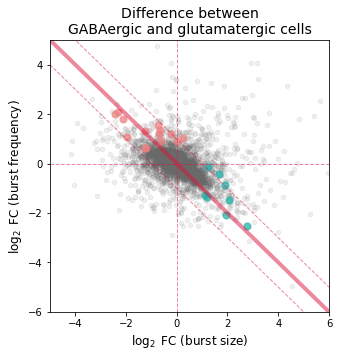

In [204]:
plt.figure(figsize=(5,5))
plt.scatter(deltaB,deltaK,ms_genes,c_genes,alpha=alpha_genes)
gf_glu_noise = (gf_glu_all[0] | gf_glu_all[1] | gf_glu_all[2])  & spliced_fc_gf 
plt.scatter(deltaB[gf_glu_noise],deltaK[gf_glu_noise],ms_highlight,aesthetics['celltype_colors_allen'][0],alpha=alpha_highlight)
gf_gaba_noise = (gf_gaba_all[0] | gf_gaba_all[1] | gf_gaba_all[2])  & spliced_fc_gf 
plt.scatter(deltaB[gf_gaba_noise],deltaK[gf_gaba_noise],ms_highlight,aesthetics['celltype_colors_allen'][1],alpha=alpha_highlight)
xl =np.asarray([-5,6])
xlx = [xl[0],xl[1]]
xly = [-xl[1],-xl[0]]
plt.xlim(xlx)
plt.ylim(xly)
plt.plot(xl,-xl,'-',linewidth=4,c='crimson',alpha=0.5)
plt.plot(xl,-(xl+1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xl,-(xl-1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xlx,[0,0],'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot([0,0],xly,'--',linewidth=1,c='crimson',alpha=0.5)
plt.xlabel(r'$\log_2$ FC (burst size)',fontsize=fs_axes)
plt.ylabel(r'$\log_2$ FC (burst frequency)',fontsize=fs_axes)
plt.title('Difference between\nGABAergic and glutamatergic cells',fontsize=fs_title)
plt.savefig('./figs/fig4a.png',dpi=450)
plt.savefig('./figs/fig4a.pdf')

# Figure 4b

Now, illustrate the distributional differences. The key idea here is that these parameter differences are not incidental: they reflect real differences in the distribution shapes.

In [120]:
dataset_ind = 0
sd_arr_allen = [monod.analysis.load_search_data('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in allen_celltypes[dataset_ind]]
sr_arr_allen = [monod.analysis.load_search_results('/home/ggorin/projects/GP_2021_3/notebooks/fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in allen_celltypes[dataset_ind]]


In [122]:
gf_glu_noise.sum()

14

In [123]:
inds_gaba = np.where((gf_gaba_noise & (gf_rej[0,:,:].all(0))))[0]
print(gn[inds_gaba])

['Fam174a' 'Socs2' 'Ankrd40' 'Rgmb' 'Dpysl3' 'Itga4' 'Bach2']


In [124]:
inds_glu = np.where((gf_glu_noise & (gf_rej[0,:,:].all(0))))[0]
print(gn[inds_glu])

['Rnf152' 'A330023F24Rik' 'Slc39a11' 'Nin' 'Mblac2' 'Cxxc4' 'Ankrd6'
 'Ccdc136' 'Stx4a' 'Crtc3' 'Egln1' 'Scg3' 'Mid2']


In [125]:
par_vals_uncorrected.shape

(4, 2, 5000, 3)

Nin
[5.98450047 1.69262372]
[3.27098321 0.97961631]
Bach2
[5.74920635 0.86984127]
[12.07434053  1.3501199 ]


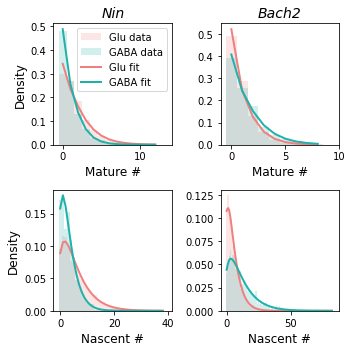

In [127]:
fig1,ax1 = plt.subplots(2,2,figsize=(5,5))
l_=1
for gene_ind,k_ in enumerate([3,6]):
    if gene_ind ==0:
        global_ind = inds_glu[k_]
    else:
        global_ind = inds_gaba[k_]
        
    glu_data = sd_arr_allen[0].layers[:,global_ind,:]
    gaba_data = sd_arr_allen[1].layers[:,global_ind,:]
    print(gn[global_ind])
    print(glu_data.mean(-1))
    print(gaba_data.mean(-1))
#     else:
#         glu_data = sd_arr_allen[0].layers[:,inds_gaba[k_],:]
#         gaba_data = sd_arr_allen[1].layers[:,inds_gaba[k_],:]
#         print(gn[inds_gaba[k_]])
        
    bins_mat = np.arange(max(glu_data[1].max(),gaba_data[1].max())+1)-0.5
    ax1[0,gene_ind].hist(glu_data[1],bins_mat,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][0],
                                                       label='Glu data')
    ax1[0,gene_ind].hist(gaba_data[1],bins_mat,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][1],
                                                       label='GABA data')
    bins_nas = np.arange(max(glu_data[0].max(),gaba_data[0].max())+1)-0.5
    ax1[1,gene_ind].hist(glu_data[0],bins_nas,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][0])
    ax1[1,gene_ind].hist(gaba_data[0],bins_nas,density=True,alpha=0.2,facecolor=aesthetics['celltype_colors_allen'][1])
    
    pars_glu = par_vals_uncorrected[dataset_ind,0,global_ind,:]
    pars_gaba = par_vals_uncorrected[dataset_ind,1,global_ind,:]
    ########
    mx = int(bins_mat[-1]+10)    
    mx_ = int(bins_mat[-1])
    pmf_glu_mat = sr_arr_allen[0].model.eval_model_pss(pars_glu,[1,mx],sr_arr_allen[0].regressor_optimum[global_ind])
    ax1[0,gene_ind].plot(np.arange(mx_),pmf_glu_mat[:mx_],color=aesthetics['celltype_colors_allen'][0],linewidth=2,label='Glu fit')
    pmf_gaba_mat = sr_arr_allen[1].model.eval_model_pss(pars_gaba,[1,mx],sr_arr_allen[1].regressor_optimum[global_ind])
    ax1[0,gene_ind].plot(np.arange(mx_),pmf_gaba_mat[:mx_],color=aesthetics['celltype_colors_allen'][1],linewidth=2,label='GABA fit')
    ##########
    mx = int(bins_nas[-1]+10)    
    mx_ = int(bins_nas[-1])
    pmf_glu_nas = sr_arr_allen[0].model.eval_model_pss(pars_glu,[mx,1],sr_arr_allen[0].regressor_optimum[global_ind])
    ax1[1,gene_ind].plot(np.arange(mx_),pmf_glu_nas[:mx_],color=aesthetics['celltype_colors_allen'][0],linewidth=2)
    pmf_gaba_nas = sr_arr_allen[1].model.eval_model_pss(pars_gaba,[mx,1],sr_arr_allen[1].regressor_optimum[global_ind])
    ax1[1,gene_ind].plot(np.arange(mx_),pmf_gaba_nas[:mx_],color=aesthetics['celltype_colors_allen'][1],linewidth=2)
    ax1[0,gene_ind].set_xlabel('Mature #',fontsize=fs_axes)
    ax1[1,gene_ind].set_xlabel('Nascent #',fontsize=fs_axes)
    ax1[0,gene_ind].set_title(gn[global_ind],fontsize=fs_title, style='italic')
ax1[0,0].legend()
ax1[0,0].set_ylabel('Density',fontsize=fs_axes)
ax1[1,0].set_ylabel('Density',fontsize=fs_axes)
    
#     print(glu_data.mean())
#     print(gaba_data.mean())
fig1.tight_layout()
plt.savefig('./figs/fig4b.png',dpi=450)
plt.savefig('./figs/fig4b.pdf')

# Figure 4c

Here, we investigate genome-wide enhancement of noise due to IdU (Desai et al. dataset). The fits are performed in a different notebook.

In [128]:
dataset_meta = ['desai_dmso','desai_idu']
dataset_names = dataset_meta 
dir_string = './fits/gg_230329_026_desai_1'
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [129]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

The technical parameter optimum is essentially not identifiable, because the dataset uses the v2 technology. We assume it's similar to parameters we have observed previously (see Figure 3 of "Length Biases..."). This decision is somewhat arbitrary, but it's about as good as we can do: the "discovered" optima are highly unstable, as evinced by the disjoint likelihood quantile.

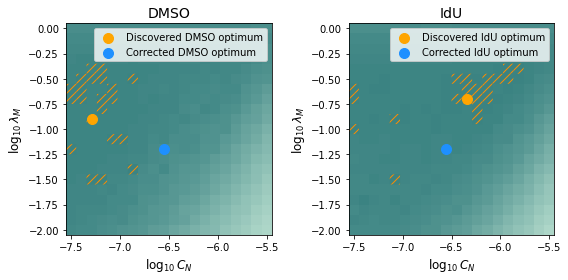

In [131]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

def plot_landscape(sr,ax):
    x_ = np.unique(sr.sp.X)
    y_ = np.unique(sr.sp.Y)
    nX = len(x_)
    nY = len(y_)
    X,Y = np.meshgrid(x_,y_,indexing='ij')
    kld = np.reshape(np.log10(sr.klds.sum(1)),sr.sp.gridsize)
#     print(kld)
    vmin = kld.min()
    vmax = kld.max()
    ax.pcolormesh(X,Y,(kld),cmap=cmap_histogram,vmin=vmin,vmax=vmax)
    q = np.quantile(kld,0.05)
    ax.pcolor(X,Y,np.ma.masked_array(kld,kld>q),
                  cmap=cmap_histogram,
                  alpha=1,hatch='///',edgecolor='darkorange',facecolor=None,linewidth=0,
                  vmin=vmin,vmax=vmax)
fig1,ax1= plt.subplots(1,2,figsize=(8,4))
names = ['DMSO','IdU']
abbr_names = names
arbitrary_v2_params = np.asarray([-6.5,-1.2])
arbitrary_v2_ind = np.argmin(((sr_arr[1].sp.sampl_vals-arbitrary_v2_params)**2).sum(1))
arbitrary_v2_pars = sr_arr[1].sp.sampl_vals[arbitrary_v2_ind]
for k in range(2):
    plot_landscape(sr_arr[k],ax1[k])
    ax1[k].scatter(sr_arr[k].samp_optimum[0],sr_arr[k].samp_optimum[1],100,c='orange',label='Discovered {} optimum'.format(abbr_names[k]))
    ax1[k].scatter(arbitrary_v2_pars[0],arbitrary_v2_pars[1],100,c='dodgerblue',label='Corrected {} optimum'.format(abbr_names[k]))
    ax1[k].set_xlabel(r'$\log_{10} C_N$',fontsize=fs_axes)
    ax1[k].set_ylabel(r'$\log_{10} \lambda_M$',fontsize=fs_axes)
    ax1[k].set_title(names[k],fontsize=fs_title)
    ax1[k].legend(loc='upper right')
fig1.tight_layout()
plt.savefig('./figs/desai_landscape.png',dpi=450)
plt.savefig('./figs/desai_landscape.pdf')


In [132]:
sr_arr[k].samp_optimum[0]

-6.342105263157895

Do a round of goodness-of-fit testing.

In [134]:
for k in range(2):
    sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)
    _=sr_arr[k].chisquare_testing(sd_arr[k],threshold=0.01)

# sr_arr[0].set_sampling_optimum(arbitrary_v2_ind)
# sr_arr

We see increases in burst size and decreases in turnover rates (i.e., increases in burst frequency?) from DMSO to IdU.

dmso: -6.55, -1.20
idu: -6.55, -1.20


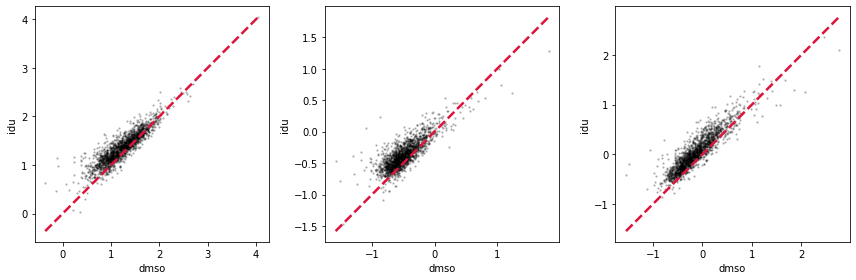

In [135]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))

print('dmso: {:.2f}, {:.2f}'.format(*sr_arr[0].samp_optimum))

print('idu: {:.2f}, {:.2f}'.format(*sr_arr[1].samp_optimum))
gf_rej = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf_rej,j]
    y = sr_arr[1].phys_optimum[gf_rej,j]
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('dmso')
    ax1[j].set_ylabel('idu')
fig1.tight_layout()

In [136]:
par_vals = np.asarray([sr_arr[0].phys_optimum,sr_arr[1].phys_optimum])

In [137]:
fc_par = ((par_vals[1,:,:]-par_vals[0,:,:])/np.log10(2))

Splicing and degradation rate changes are fairly correlated (though less so than we observe in, e.g. Section S7.10.3 of "Length Biases...", likely due to the v2 technology). Note also that we get fairly considerable co-variation of burst size and turnover rates, which is probably because of meaningful synchronized and compensating changes in transcriptional parameters.

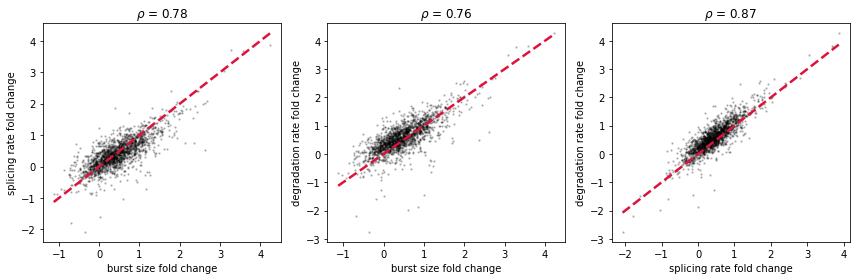

In [138]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]
parnames = ('burst size','splicing rate','degradation rate')
for j,pair in enumerate(pairs):
    x = fc_par[gf_rej,pair[0]]
    y = fc_par[gf_rej,pair[1]]
    rho = np.corrcoef(x,y)[0,1]
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel(parnames[pair[0]] + ' fold change')
    ax1[j].set_ylabel(parnames[pair[1]] + ' fold change')
    ax1[j].set_title(r'$\rho$ = '+'{:.2f}'.format(rho))
fig1.tight_layout()

In [139]:
deltaB = fc_par[:,0]
deltaK = -(fc_par[:,1]+fc_par[:,2])/2

In [140]:
markers = ['Nanog','Sox2', 'Pou5f1','Klf4','Wdr83','Stx7','Hif1an','Mtpap','Farsa','Wipi2','Snd1']

In [141]:
gn = sr_arr[0].gene_names

In [142]:
marker_inds = [np.where(gn==mk)[0][0] for mk in markers]

In [143]:
gf_rej[marker_inds]

array([False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True])

Have we discovered anything about the markers? A limited amount. The fits are poor.

In [144]:
for i,mi in enumerate(marker_inds):
    print('{}. Rejected: {}. Mean in DMSO: {:.2f}. Mean in IdU: {:.2f}.\n\tBurst size fc: {:2f}.\n\tBurst freq fc: {:.2f}.'.format(
        markers[i],~gf_rej[mi],sd_arr[0].layers[1,mi,:].mean(),sd_arr[1].layers[1,mi,:].mean(),\
        deltaB[mi],deltaK[mi]))

Nanog. Rejected: True. Mean in DMSO: 13.46. Mean in IdU: 8.51.
	Burst size fc: 0.532120.
	Burst freq fc: -1.22.
Sox2. Rejected: False. Mean in DMSO: 0.00. Mean in IdU: 0.00.
	Burst size fc: 0.000000.
	Burst freq fc: -0.00.
Pou5f1. Rejected: True. Mean in DMSO: 10.30. Mean in IdU: 8.42.
	Burst size fc: -9.216237.
	Burst freq fc: 5.28.
Klf4. Rejected: True. Mean in DMSO: 13.44. Mean in IdU: 9.90.
	Burst size fc: 10.054566.
	Burst freq fc: -7.01.
Wdr83. Rejected: False. Mean in DMSO: 2.59. Mean in IdU: 1.94.
	Burst size fc: -0.089273.
	Burst freq fc: -0.17.
Stx7. Rejected: False. Mean in DMSO: 1.47. Mean in IdU: 1.41.
	Burst size fc: 4.237180.
	Burst freq fc: -4.07.
Hif1an. Rejected: False. Mean in DMSO: 0.44. Mean in IdU: 0.32.
	Burst size fc: -1.126197.
	Burst freq fc: 0.77.
Mtpap. Rejected: False. Mean in DMSO: 1.87. Mean in IdU: 1.58.
	Burst size fc: 1.272200.
	Burst freq fc: -1.54.
Farsa. Rejected: False. Mean in DMSO: 7.44. Mean in IdU: 6.07.
	Burst size fc: 0.365224.
	Burst freq fc

In [145]:
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 50
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'


In [146]:
thrpars = 1.5
thrmean = 1
gf_highnoise = (np.abs(deltaB)>thrpars) & (np.abs(deltaK)>thrpars)  \
    & ((sd_arr[1].layers[1].mean(1)>thrmean) | (sd_arr[0].layers[1].mean(1)>thrmean)) \
    & gf_rej

In [147]:
gf_highnoise.sum()

11

Summarize the results for genes with highest-magnitude changes in noise, filtering for "interesting" ones with nontrivial expression.

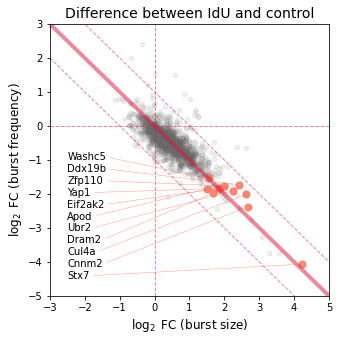

In [179]:
plt.figure(figsize=(5,5))
plt.scatter(deltaB[gf_rej],deltaK[gf_rej],ms_genes,c_genes,alpha=alpha_genes)
plt.scatter(deltaB[gf_highnoise],deltaK[gf_highnoise],ms_highlight,c_highlight,alpha=alpha_highlight)
INDS = np.where(gf_highnoise)[0]
INDS = np.flip(INDS[np.argsort(deltaK[INDS])])
for i_,gind in enumerate(INDS):
    xy=(deltaB[gind],deltaK[gind])
    xytext = [-2.5,-1-0.35*i_]
    plt.annotate(gn[gind],xy,xytext,
                 arrowprops={'linewidth':0.5,'color':c_highlight,
                             'alpha':0.6,'relpos':(1,0.5),'arrowstyle':'-'})
xl =np.asarray([-3,5])
xlx = [xl[0],xl[1]]
xly = [-xl[1],-xl[0]]
plt.xlim(xlx)
plt.ylim(xly)
plt.plot(xl,-xl,'-',linewidth=4,c='crimson',alpha=0.5)
plt.plot(xl,-(xl+1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xl,-(xl-1),'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot(xlx,[0,0],'--',linewidth=1,c='crimson',alpha=0.5)
plt.plot([0,0],xly,'--',linewidth=1,c='crimson',alpha=0.5)
plt.xlabel(r'$\log_2$ FC (burst size)',fontsize=fs_axes)
plt.ylabel(r'$\log_2$ FC (burst frequency)',fontsize=fs_axes)
plt.title('Difference between IdU and control',fontsize=fs_title)

plt.savefig('./figs/fig4c.png',dpi=450)
plt.savefig('./figs/fig4c.pdf')

In [177]:
gn = sr_arr[0].gene_names

In [178]:
for x in gn[gf_highnoise]:
    print(x)

Stx7
Washc5
Apod
Eif2ak2
Ubr2
Cnnm2
Dram2
Zfp110
Cul4a
Ddx19b
Yap1
